In [1]:
from __future__ import division, print_function, absolute_import
import tensorboard
import tflearn

# Residual blocks
# 32 layers: n=5, 56 layers: n=9, 110 layers: n=18
n = 5

# Data loading
#import h5py
#h5f = h5py.File('../../train.h5', 'r')
#X = h5f['X']
#Y = h5f['Y']

#h5f_test = h5py.File('../../test.h5', 'r')
#testX = h5f_test['X']
#testY = h5f_test['Y']


# Real-time data preprocessing
img_prep = tflearn.ImagePreprocessing()
img_prep.add_featurewise_zero_center(per_channel=True, mean=[0.53990436 , 0.4405486  , 0.39328504])

# Real-time data augmentation
img_aug = tflearn.ImageAugmentation()
img_aug.add_random_flip_leftright()
img_aug.add_random_crop([49, 49], padding=4)

# Building Residual Network
net = tflearn.input_data(shape=[None, 49, 49, 3],
                         data_preprocessing=img_prep,
                         data_augmentation=img_aug)
net = tflearn.conv_2d(net, 16, 3, regularizer='L2', weight_decay=0.0001)
net = tflearn.resnext_block(net, n, 16, 32)
net = tflearn.resnext_block(net, 1, 32, 32, downsample=True)
net = tflearn.resnext_block(net, n-1, 32, 32)
net = tflearn.resnext_block(net, 1, 64, 32, downsample=True)
net = tflearn.resnext_block(net, n-1, 64, 32)
net = tflearn.batch_normalization(net)
net = tflearn.activation(net, 'relu')
net = tflearn.global_avg_pool(net)
# Regression
net = tflearn.fully_connected(net, 11, activation='softmax')
opt = tflearn.Momentum(0.1, lr_decay=0.1, decay_step=32000, staircase=True)
net = tflearn.regression(net, optimizer=opt,
                         loss='categorical_crossentropy')
# Training
model = tflearn.DNN(net, checkpoint_path='Snapshots/model_resnext',
                    max_checkpoints=10, tensorboard_verbose=0, tensorboard_dir='Logs/',
                    clip_gradients=0.)

curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


In [2]:
model.load('model_resnext-96000')

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from C:\Users\nishq\Desktop\Tensorflow-Bootcamp-master_backup\Infinite Analytics\Emotion Detection\model_resnext-96000


In [5]:
import glob
import pandas as pd
import operator
import tensorflow as tf 
import numpy as np


output_dict = {}

output_dict['Filepath'] = []
output_dict['Label'] = []
output_dict['Neutral Confidence'] = []
output_dict['Happy Confidence'] = []
output_dict['Sad Confidence'] = []
output_dict['Surprise Confidence'] = []
output_dict['Fear Confidence'] = []
output_dict['Disgust Confidence'] = []
output_dict['Anger Confidence'] = []
output_dict['Contempt Confidence'] = []
output_dict['None Confidence'] = []
output_dict['Uncertain Confidence'] = []
output_dict['No-Face Confidence']  = []
sess= tf.Session()

html = """<!DOCTYPE html> 
<html>

<head>
    <link rel="stylesheet" href="style.css">
    <title>AffectNet Pretrained Model Testing</title>
</head>
<body>
    <center>
        <h1>AffectNet Pretrained Model testing</h1>
    </center>"""



# ----------------------------------------------------------------------------- Get all happy-labelled images
html+= """<center>
        <h1>Smiling</h1>
    </center>
    
    <table align="center" >

        <tr>
            
            <th align="center" width=200 >Photo</th>
            <th align="center" width=200 >Emotion</th>
            <th align="center" width=200 >Emotion Confidence</th>
            
        </tr>"""


for filepath in glob.iglob('FEI_frontal/*b.jpg'):
    print(filepath)
    
    img = tf.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img.set_shape([None, None, 3])
    img = tf.image.resize_images(img, (49, 49))
    img = img.eval(session=sess) # convert to numpy array
    img = np.expand_dims(img, 0) # make 'batch' of 1
    img = img/255.0
    
    prediction = model.predict(img)
    
    emotion_dict = {}
    emotion_dict['Neutral'] = prediction[0][0]
    emotion_dict['Happy'] = prediction[0][1]
    emotion_dict['Sad'] = prediction[0][2]
    emotion_dict['Surprise'] = prediction[0][3]
    emotion_dict['Fear'] = prediction[0][4]
    emotion_dict['Disgust'] = prediction[0][5]
    emotion_dict['Anger'] = prediction[0][6]
    emotion_dict['Contempt'] = prediction[0][7]
    emotion_dict['None'] = prediction[0][8]
    emotion_dict['Uncertain'] = prediction[0][9]
    emotion_dict['No-Face'] = prediction[0][10]
    
    output_dict['Filepath'].append(filepath)
    output_dict['Label'].append('Happy')
    output_dict['Neutral Confidence'].append(prediction[0][0])
    output_dict['Happy Confidence'].append(prediction[0][1])
    output_dict['Sad Confidence'].append(prediction[0][2])
    output_dict['Surprise Confidence'].append(prediction[0][3])
    output_dict['Fear Confidence'].append(prediction[0][4])
    output_dict['Disgust Confidence'].append(prediction[0][5])
    output_dict['Anger Confidence'].append(prediction[0][6])
    output_dict['Contempt Confidence'].append(prediction[0][7])
    output_dict['None Confidence'].append(prediction[0][8])
    output_dict['Uncertain Confidence'].append(prediction[0][9])
    output_dict['No-Face Confidence'].append(prediction[0][10]) 
    
    emotion = str(max(emotion_dict.items(), key=operator.itemgetter(1))[0])
    emotion_confidence = max(emotion_dict.items(), key=operator.itemgetter(1))[1] *100
    
    html+= """<tr align="center">

                <td><img src="""+'"'+str(filepath)+'"'+""" alt="" border=3 height=200 width=200></img></td>
                <td align="center" height=200 width=200 >"""+emotion+"""</td>
                <td align="center" height=200 width=200 >"""+str(round(emotion_confidence))+"""%</td>

            </tr>"""
    print(emotion)
    print(emotion_confidence)
    
html+="""</table>"""


# ----------------------------------------------------------------------------- Get all neutral-labelled images

html+= """<center>
        <h1>Neutral</h1>
    </center>
    
    <table align="center" >

        <tr>
            
            <th align="center" width=200 >Photo</th>
            <th align="center" width=200 >Emotion</th>
            <th align="center" width=200 >Emotion Confidence</th>
            
        </tr>"""


for filepath in glob.iglob('FEI_frontal/*a.jpg'):
    print(filepath)
    
    img = tf.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img.set_shape([None, None, 3])
    img = tf.image.resize_images(img, (49, 49))
    img = img.eval(session=sess) # convert to numpy array
    img = np.expand_dims(img, 0) # make 'batch' of 1
    img = img/255.0
    
    prediction = model.predict(img)
    
    emotion_dict = {}
    emotion_dict['Neutral'] = prediction[0][0]
    emotion_dict['Happy'] = prediction[0][1]
    emotion_dict['Sad'] = prediction[0][2]
    emotion_dict['Surprise'] = prediction[0][3]
    emotion_dict['Fear'] = prediction[0][4]
    emotion_dict['Disgust'] = prediction[0][5]
    emotion_dict['Anger'] = prediction[0][6]
    emotion_dict['Contempt'] = prediction[0][7]
    emotion_dict['None'] = prediction[0][8]
    emotion_dict['Uncertain'] = prediction[0][9]
    emotion_dict['No-Face'] = prediction[0][10]
    
    output_dict['Filepath'].append(filepath)
    output_dict['Label'].append('Neutral')
    output_dict['Neutral Confidence'].append(prediction[0][0])
    output_dict['Happy Confidence'].append(prediction[0][1])
    output_dict['Sad Confidence'].append(prediction[0][2])
    output_dict['Surprise Confidence'].append(prediction[0][3])
    output_dict['Fear Confidence'].append(prediction[0][4])
    output_dict['Disgust Confidence'].append(prediction[0][5])
    output_dict['Anger Confidence'].append(prediction[0][6])
    output_dict['Contempt Confidence'].append(prediction[0][7])
    output_dict['None Confidence'].append(prediction[0][8])
    output_dict['Uncertain Confidence'].append(prediction[0][9])
    output_dict['No-Face Confidence'].append(prediction[0][10]) 
    
    emotion = str(max(emotion_dict.items(), key=operator.itemgetter(1))[0])
    emotion_confidence = max(emotion_dict.items(), key=operator.itemgetter(1))[1] *100
    
    html+= """<tr align="center">

                <td><img src="""+'"'+str(filepath)+'"'+""" alt="" border=3 height=200 width=200></img></td>
                <td align="center" height=200 width=200 >"""+emotion+"""</td>
                <td align="center" height=200 width=200 >"""+str(round(emotion_confidence))+"""%</td>

            </tr>"""
    print(emotion)
    print(emotion_confidence)
    
html+="""</table>"""

html+="""</body>"""
Html_file= open("AffectNet_FEI_observation_test_output.html","w",encoding="utf-8")
Html_file.write(html)
Html_file.close()

df = pd.DataFrame(output_dict)
df.to_csv('AffectNet_FEI_raw_test_data_output.csv')

FEI_frontal\100b.jpg
Happy
96.85356020927429
FEI_frontal\101b.jpg
Happy
75.50677061080933
FEI_frontal\102b.jpg
Happy
73.7402856349945
FEI_frontal\103b.jpg
Happy
97.52349257469177
FEI_frontal\104b.jpg
Happy
73.36391806602478
FEI_frontal\105b.jpg
Happy
98.00311326980591
FEI_frontal\106b.jpg
Happy
95.81490159034729
FEI_frontal\107b.jpg
Happy
89.09709453582764
FEI_frontal\108b.jpg
Happy
90.39613008499146
FEI_frontal\109b.jpg
Happy
79.63216304779053
FEI_frontal\10b.jpg
Happy
79.27834391593933
FEI_frontal\110b.jpg
Happy
58.80449414253235
FEI_frontal\111b.jpg
Happy
52.68571376800537
FEI_frontal\112b.jpg
Happy
90.76911807060242
FEI_frontal\113b.jpg
Happy
90.55947065353394
FEI_frontal\114b.jpg
Happy
69.62067484855652
FEI_frontal\115b.jpg
Happy
88.66569399833679
FEI_frontal\116b.jpg
Happy
80.88290095329285
FEI_frontal\117b.jpg
Happy
85.58138608932495
FEI_frontal\118b.jpg
Happy
88.8358473777771
FEI_frontal\119b.jpg
Happy
90.72123765945435
FEI_frontal\11b.jpg
Happy
61.36311888694763
FEI_frontal\12

Happy
59.2267632484436
FEI_frontal\87b.jpg
No-Face
64.37748074531555
FEI_frontal\88b.jpg
Happy
85.24803519248962
FEI_frontal\89b.jpg
Happy
95.93432545661926
FEI_frontal\8b.jpg
Happy
93.13724637031555
FEI_frontal\90b.jpg
Happy
92.30022430419922
FEI_frontal\91b.jpg
Happy
91.47948026657104
FEI_frontal\92b.jpg
Happy
68.68836283683777
FEI_frontal\93b.jpg
Happy
89.43386673927307
FEI_frontal\94b.jpg
Happy
74.8525857925415
FEI_frontal\95b.jpg
Happy
76.80295705795288
FEI_frontal\96b.jpg
Happy
96.99903130531311
FEI_frontal\97b.jpg
Happy
95.19208073616028
FEI_frontal\98b.jpg
Happy
91.60079956054688
FEI_frontal\99b.jpg
Happy
90.70939421653748
FEI_frontal\9b.jpg
Happy
94.30067539215088
FEI_frontal\100a.jpg
Neutral
37.98264563083649
FEI_frontal\101a.jpg
Sad
69.31707859039307
FEI_frontal\102a.jpg
No-Face
49.915966391563416
FEI_frontal\103a.jpg
Happy
65.71638584136963
FEI_frontal\104a.jpg
No-Face
47.189512848854065
FEI_frontal\105a.jpg
Neutral
54.897648096084595
FEI_frontal\106a.jpg
Neutral
36.9715809

Neutral
48.63274097442627
FEI_frontal\67a.jpg
Neutral
58.44808220863342
FEI_frontal\68a.jpg
Neutral
68.29468607902527
FEI_frontal\69a.jpg
Neutral
38.43489587306976
FEI_frontal\6a.jpg
Neutral
31.367123126983643
FEI_frontal\70a.jpg
Neutral
46.166861057281494
FEI_frontal\71a.jpg
Happy
59.96290445327759
FEI_frontal\72a.jpg
Happy
42.432817816734314
FEI_frontal\73a.jpg
Neutral
37.853455543518066
FEI_frontal\74a.jpg
Neutral
45.08648216724396
FEI_frontal\75a.jpg
No-Face
80.36466836929321
FEI_frontal\76a.jpg
No-Face
37.80970573425293
FEI_frontal\77a.jpg
No-Face
56.85069561004639
FEI_frontal\78a.jpg
Neutral
57.75713324546814
FEI_frontal\79a.jpg
No-Face
42.90069043636322
FEI_frontal\7a.jpg
Sad
49.3319571018219
FEI_frontal\80a.jpg
Neutral
47.50116467475891
FEI_frontal\81a.jpg
Neutral
42.08039045333862
FEI_frontal\82a.jpg
No-Face
59.089094400405884
FEI_frontal\83a.jpg
Neutral
57.2689950466156
FEI_frontal\84a.jpg
No-Face
45.30545175075531
FEI_frontal\85a.jpg
Neutral
51.647984981536865
FEI_frontal\86

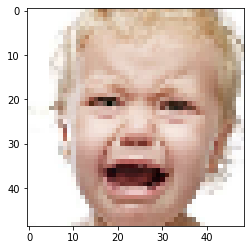

In [10]:
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
tf.enable_eager_execution()
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, [49, 49])
    image /= 255.0  # normalize to [0,1] range

    return image

def load_and_preprocess_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

img = load_and_preprocess_image('test.jpg')
plt.imshow(img)
plt.grid(False)


In [57]:
img

<tf.Tensor 'truediv_7:0' shape=(192, 192, 3) dtype=float32>

TypeError: Image data cannot be converted to float

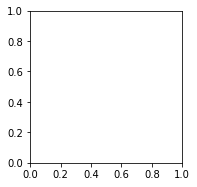

In [61]:
from scipy import misc
import tensorflow as tf

#img = misc.imread('test.jpg')
#print(img.shape)    # (32, 32, 3)

#img_tf = tf.Variable(img)
#print(img_tf.get_shape().as_list())

img_tf = tf.read_file('test.jpg')

init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
im = sess.run(img_tf)

import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(im)
fig.add_subplot(1,2,2)
plt.imshow(img)
plt.show()

C:\Users\nishq\Anaconda3\envs\tfdeeplearning\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x00000205A5DAAB70> (for post_execute):


KeyboardInterrupt: 

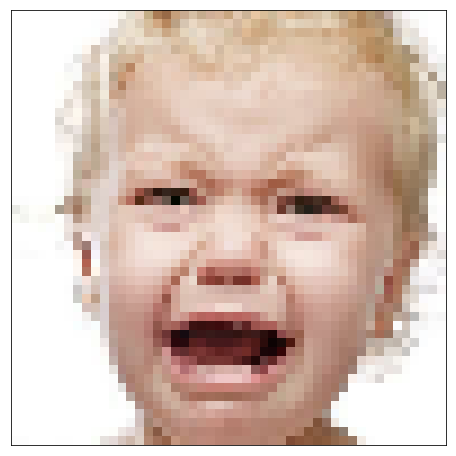

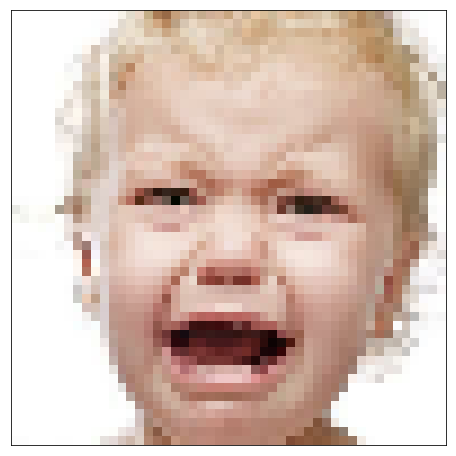

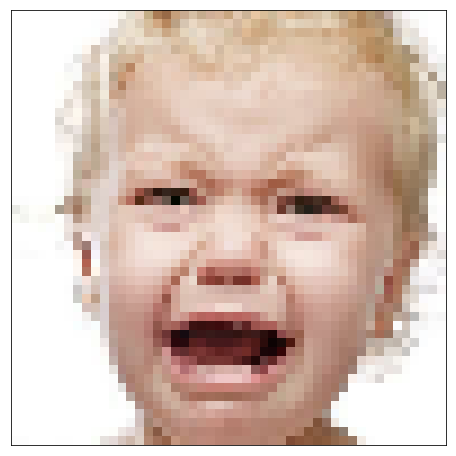

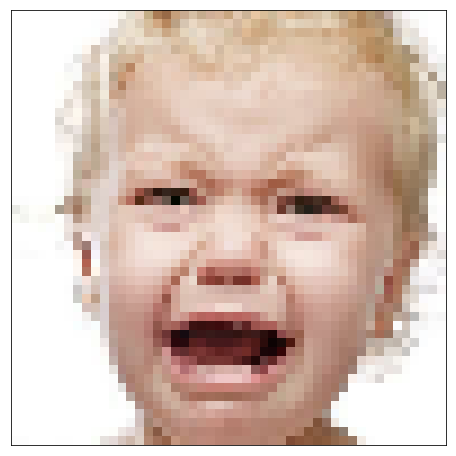

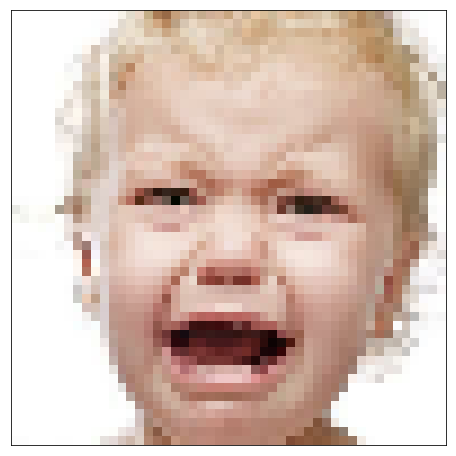

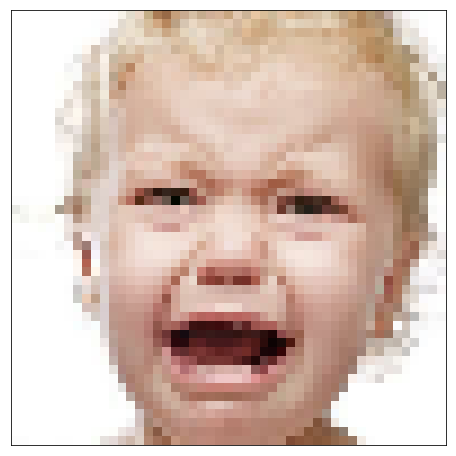

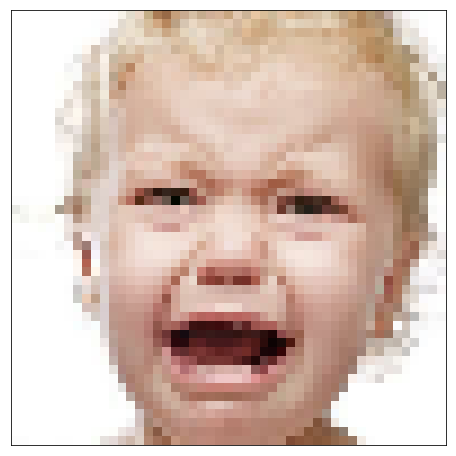

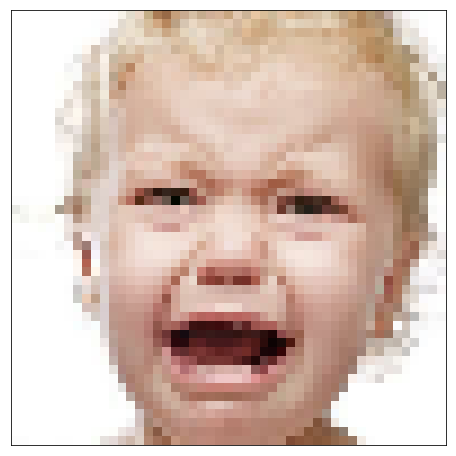

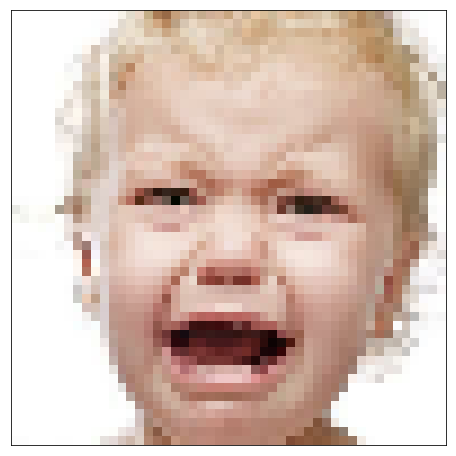

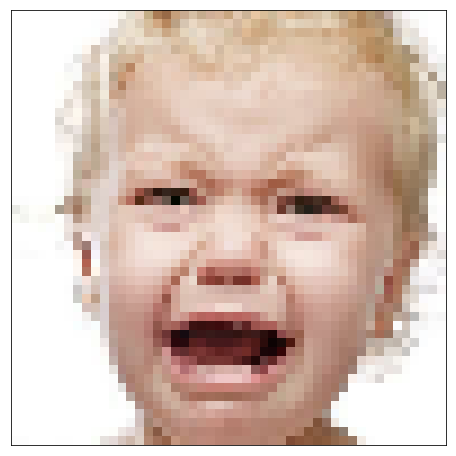

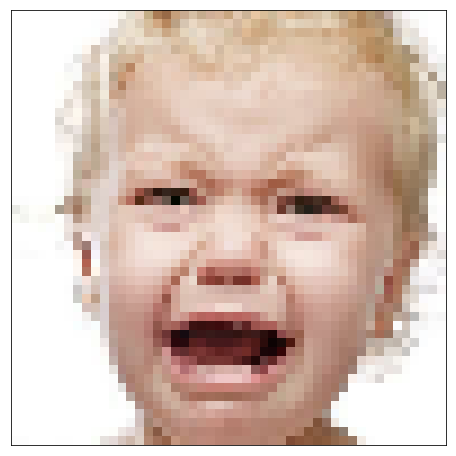

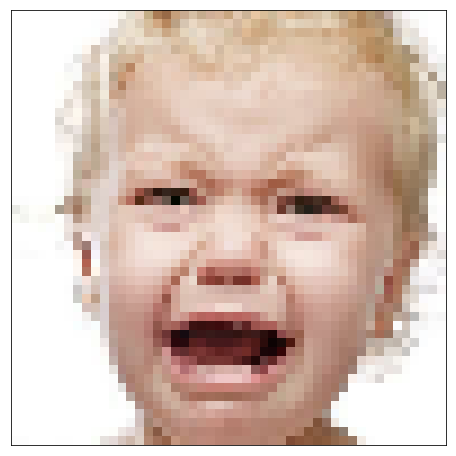

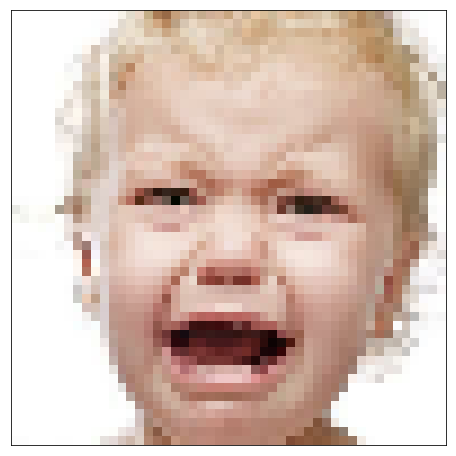

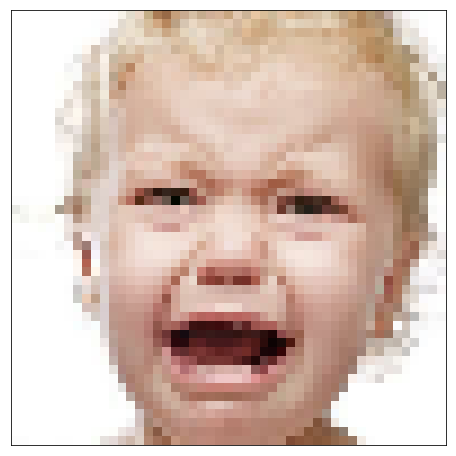

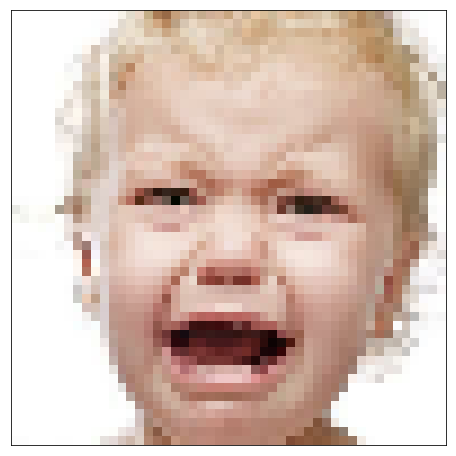

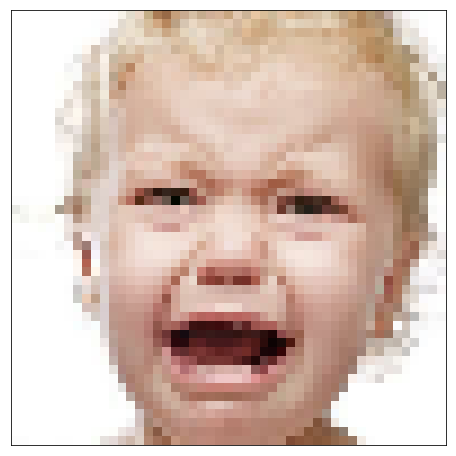

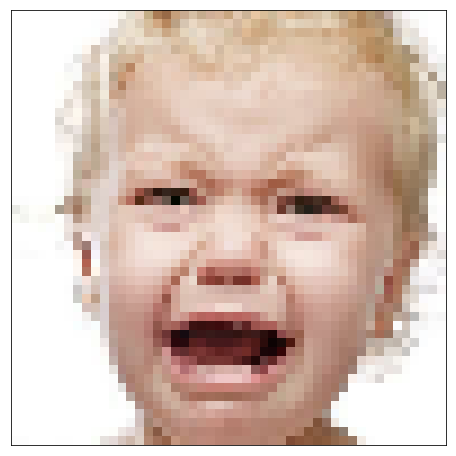

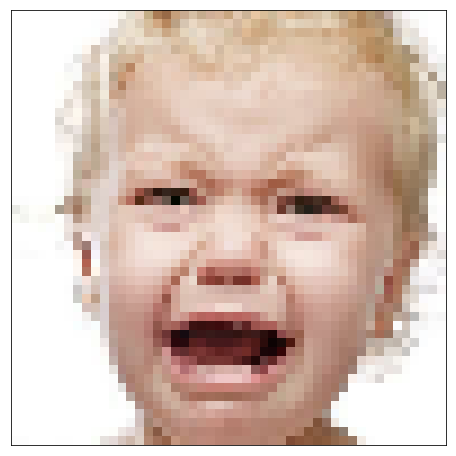

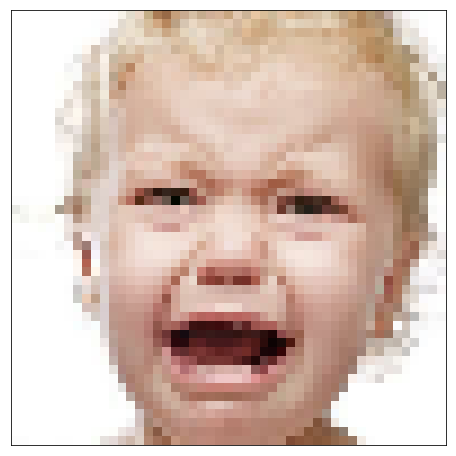

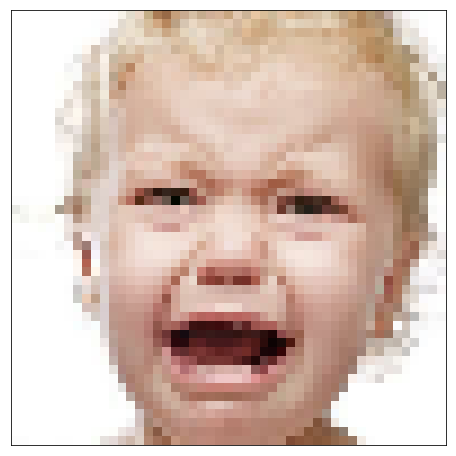

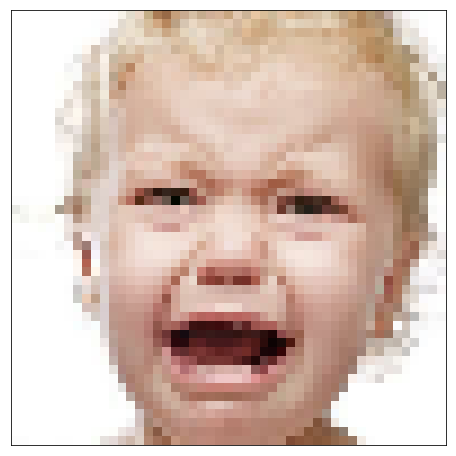

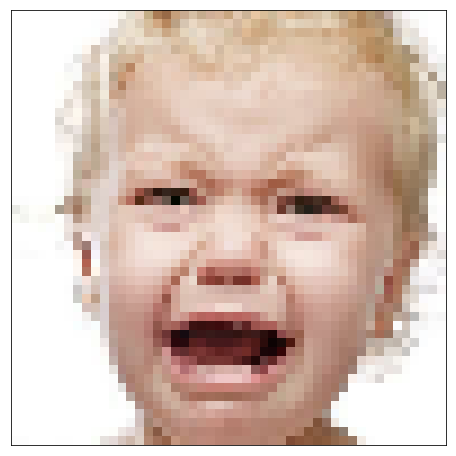

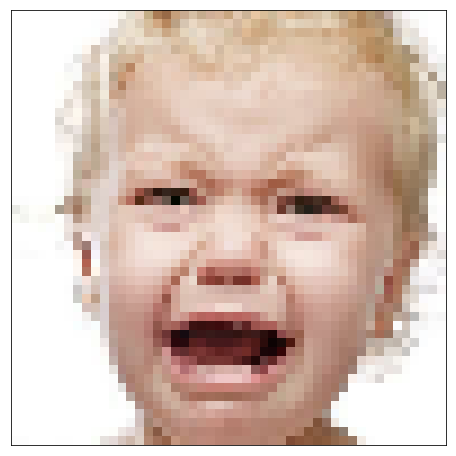

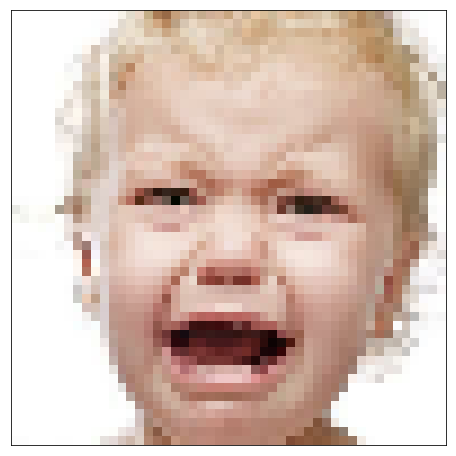

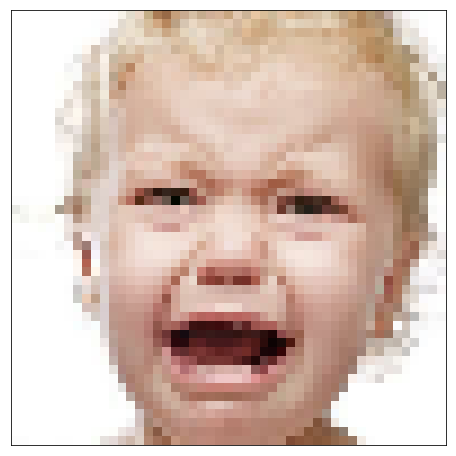

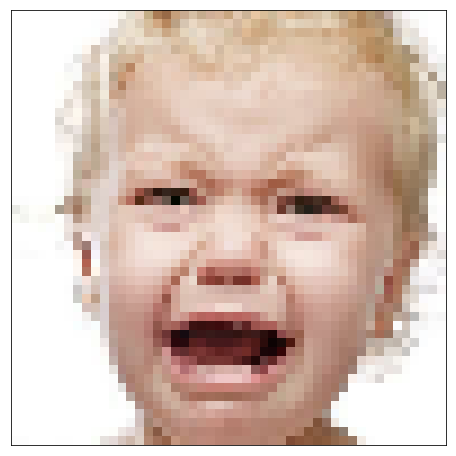

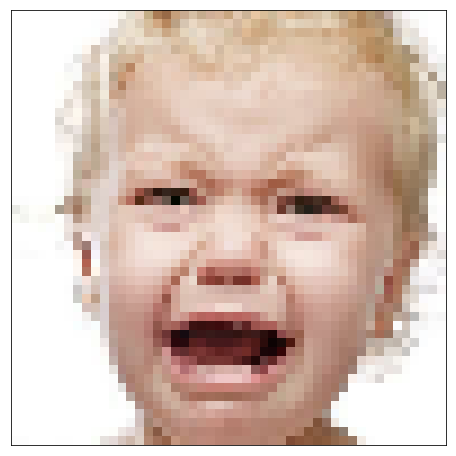

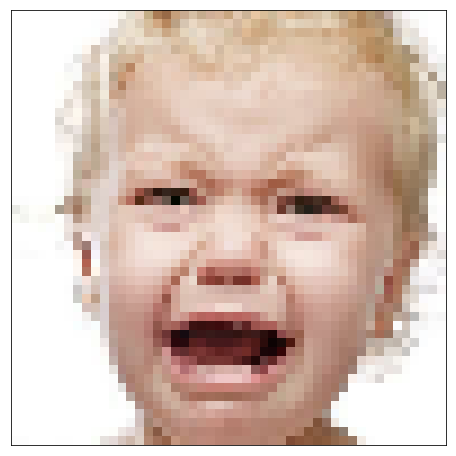

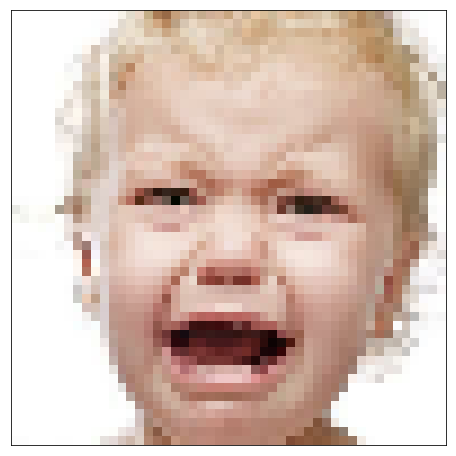

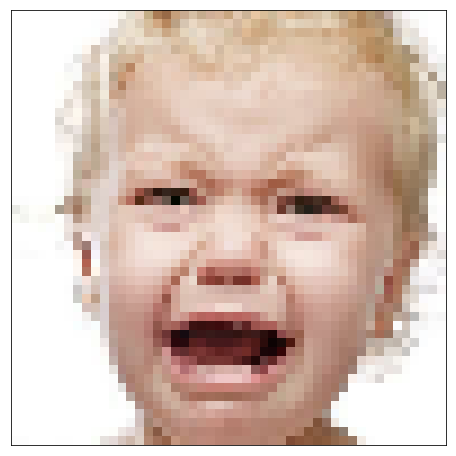

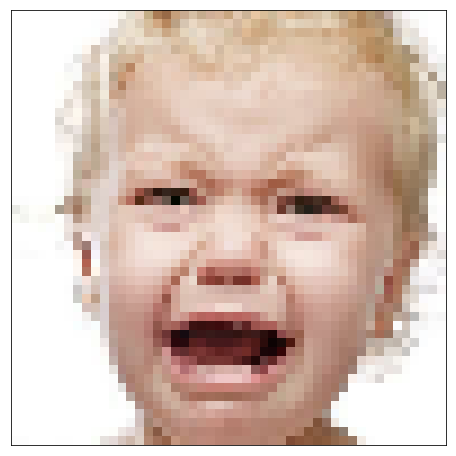

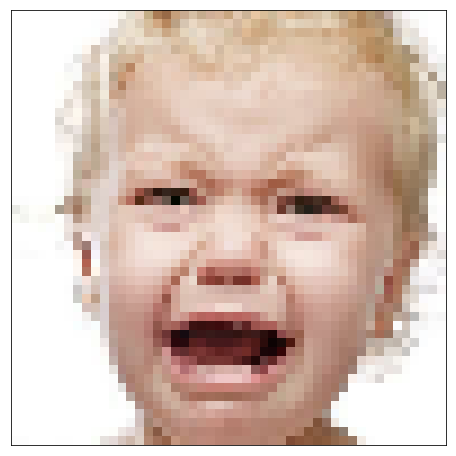

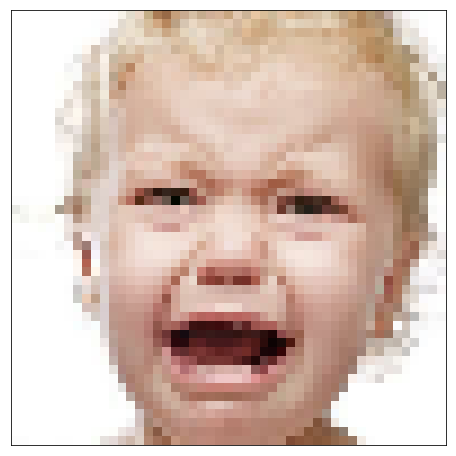

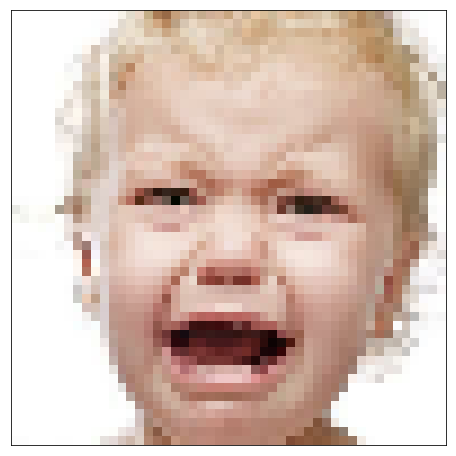

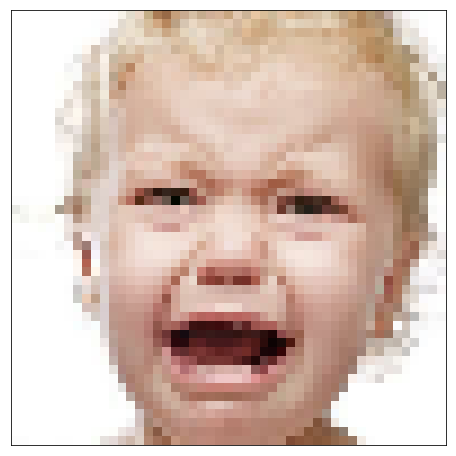

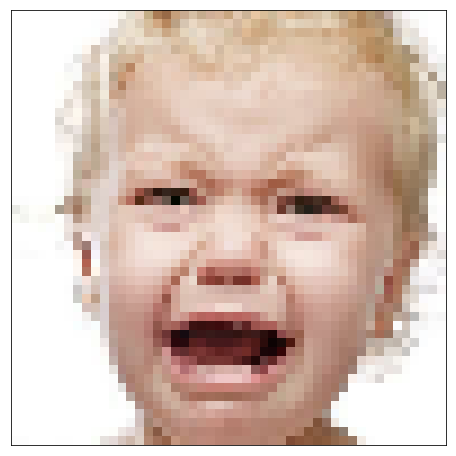

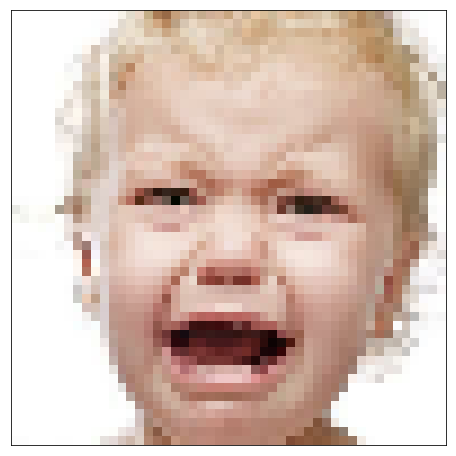

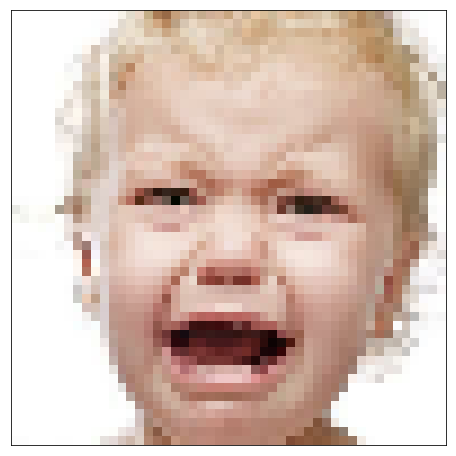

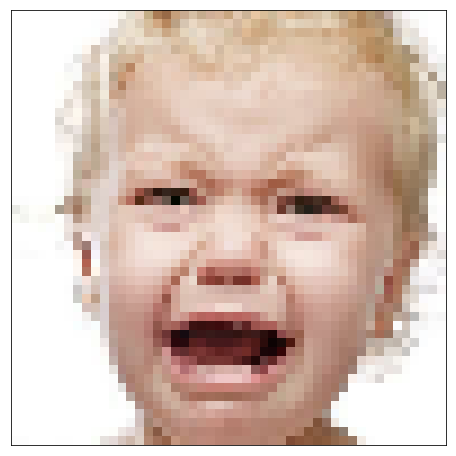

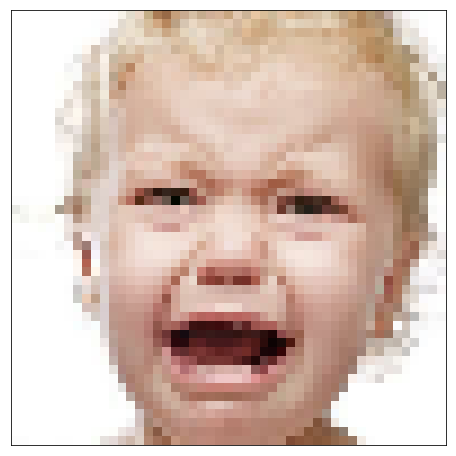

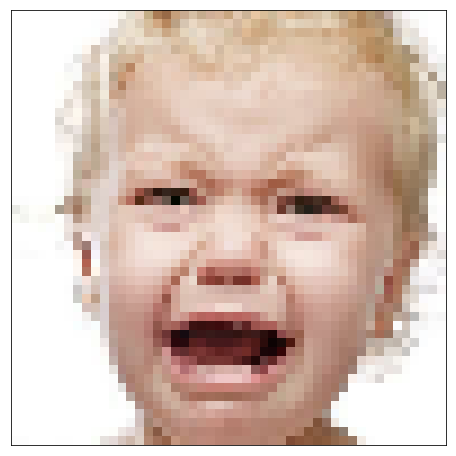

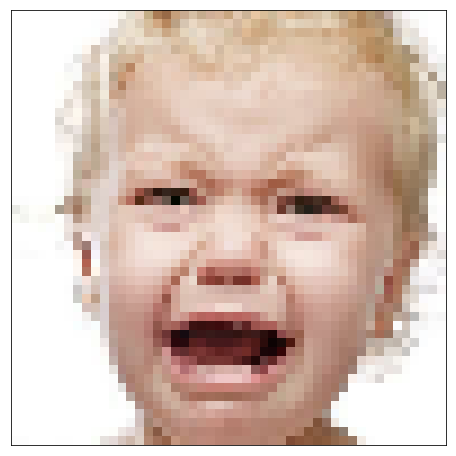

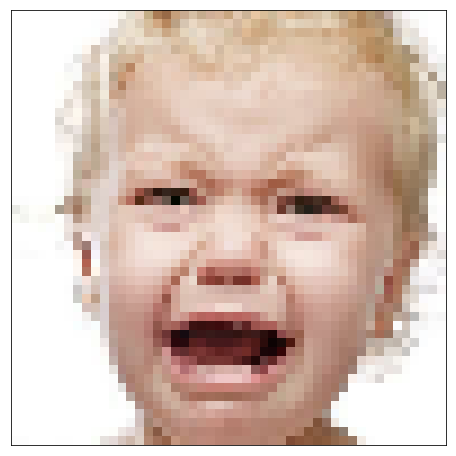

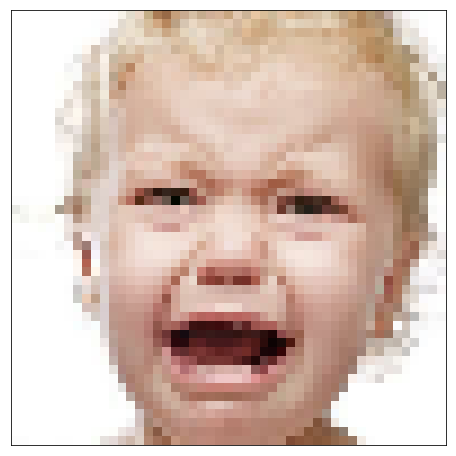

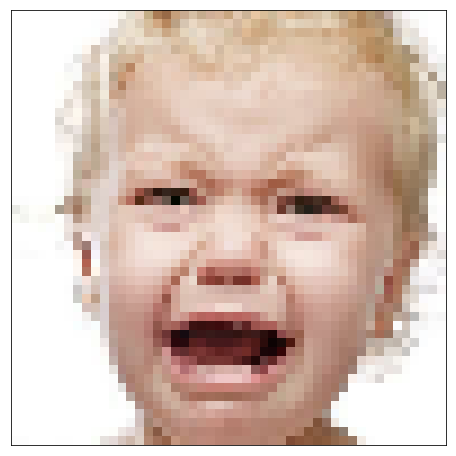

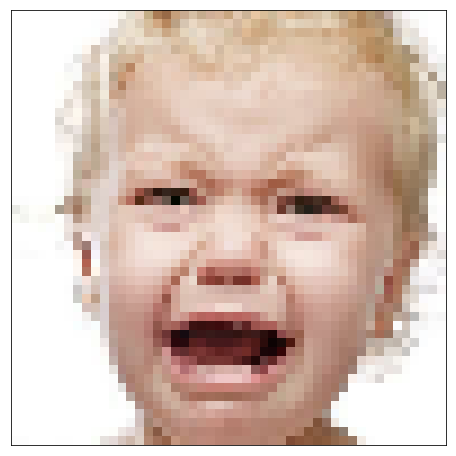

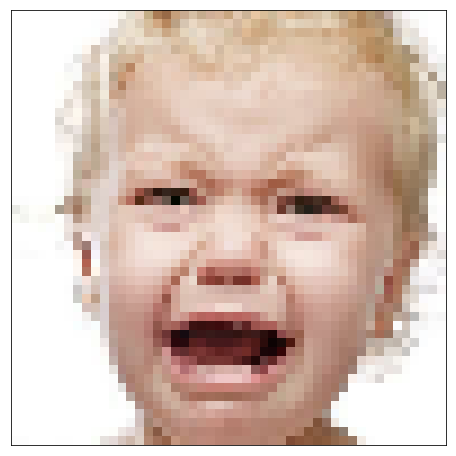

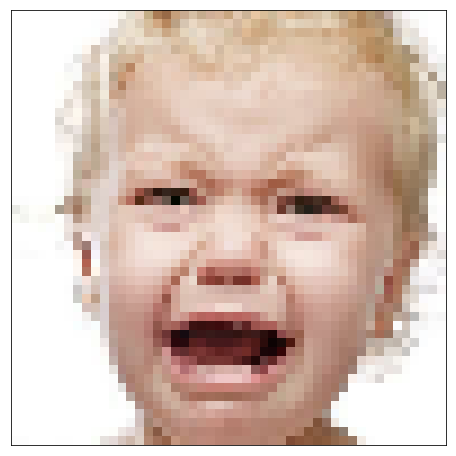

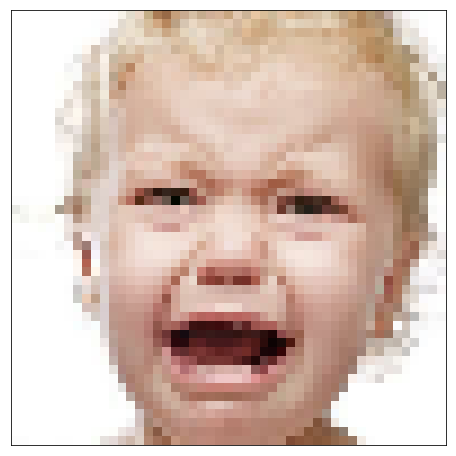

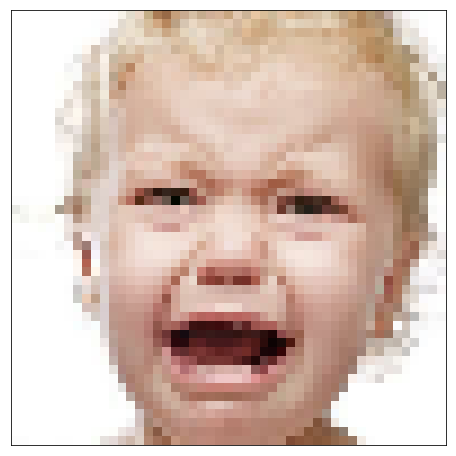

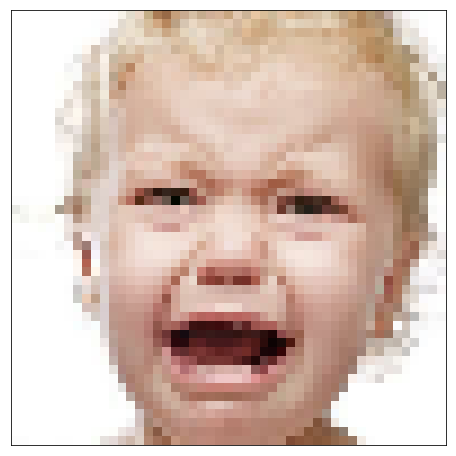

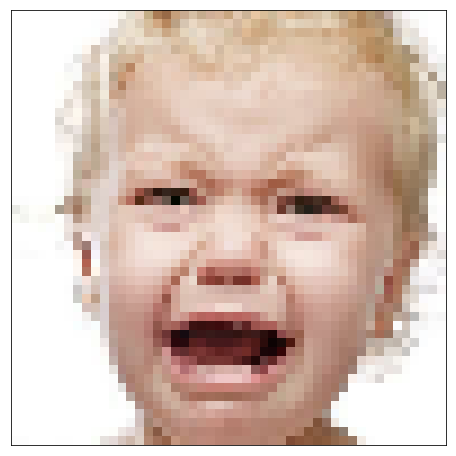

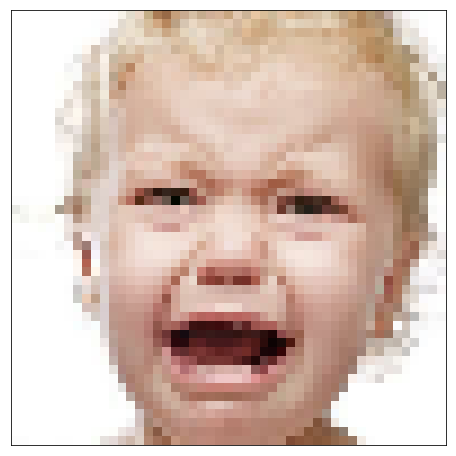

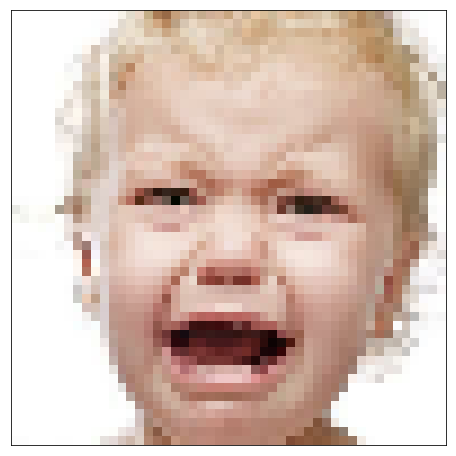

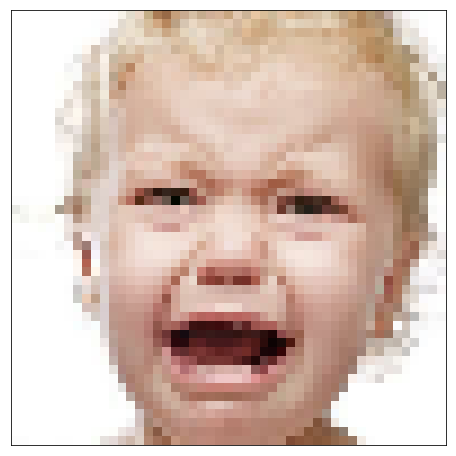

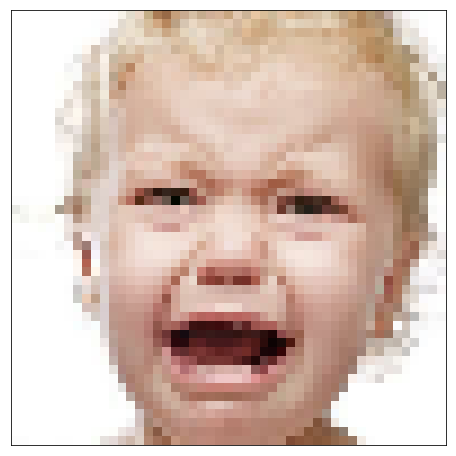

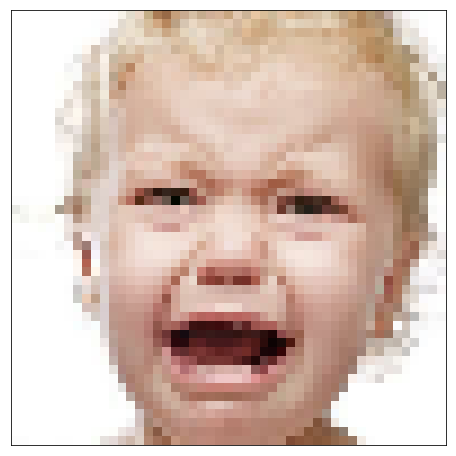

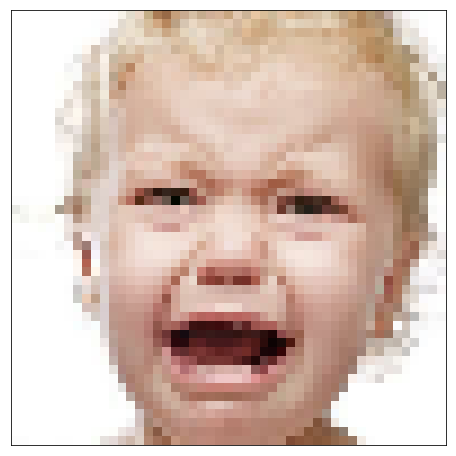

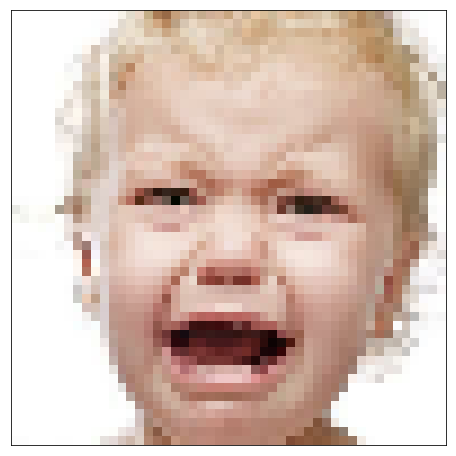

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline


def load_and_preprocess_jpeg(imagepath):
    img = tf.read_file(imagepath)
    img_tensor = tf.image.decode_jpeg(img)
    img_tensor = tf.image.resize_images(img_tensor, [49,49])
    img_tensor = tf.cast(img_tensor, tf.float32, name='ImageCast')
    img_tensor /= 255.0 
    return img_tensor

#path_Dataset = tf.data.Dataset.from_tensor_slices('test.jpg','download.jpg')
#image_Dataset = path_Dataset.map(load_and_preprocess_jpeg)
#temp_DS = image_Dataset.take(4)
#itera = temp_DS.make_one_shot_iterator()
image = load_and_preprocess_jpeg('test.jpg')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    while True:
        try:
            image_to_plot = sess.run(image)
            plt.figure(figsize=(8,8))
            #plt.subplot(2,2,n+1)
            plt.imshow(image_to_plot)
            plt.grid(False)
            plt.xticks([])
            plt.yticks([])

        except tf.errors.OutOfRangeError:
            break 

In [ ]:
tf.data.Dataset.from_tensor_slices()